## Test asymmetry and wind shear

<u>Conclusion</u>: Pour les cas où le wind shear est faible (en bleu), l'amplitude de l'asymétrie décroît avec le rayon au delà du Rmax, et est en moyenne 1 m/s en dessous de la vitesse de translation du TC, ce qui est bien reproduit par le modèle Kepert en général. Pour les cas où le wind shear est fort (en rouge), l'amplitude de l'asymétrie croît avec le rayon au delà du Rmax, ce qui n'est pas reproduit par le modèle de Kepert. En outre, à partir de r > 3*Rmax, l'amplitude de l'asymétrie est proche de la vitesse de translation du TC pour ces cas (rouges), ce qui n'est pas non plus reproduit par le modèle.

Pour tous ces cas mélangés (wind shear fort et faible), l'asymétrie est constante avec r (pour r > Rmax) et 1 m/s en dessous du storm motion lorsque le motion vector est downshear-left. Cela est attendu car dans une telle configuration le motion vector et le wind shear sont sensés avoir la même contribution sur l'asymétrie convective (Corbosiero et Molinari 2003). L'asymétrie décroît avec r (pour r > Rmax) bien en dessous de 1 m/s en dessous du storm motion lorsque le motion vector est à droite du wind shear vector (both downshear-right and upshear-right). L'asymétrie croît avec r (pour r > Rmax) lorsque le motion vector est upshear-left.

En bref, si je regarde les cas pour lesquels le motion vector est downshear-left, les asymétries devraient être cohérentes avec Kepert.

Rappel: Downshear = in the direction of the vertical wind shear vector.

<u>NB</u>: Les cas à fort wind shear ont un Rmax plus petit en moyenne que les cas à faible wind shear. Cela semble significatif.

<u>NB</u>: Moyenne des Rmax

- Downshear-left: 25km
- Downshear-right: 27km
- Upshear-right: 29km
- Upshear-left: 25km

TODO: Traiter l'hémisphère Sud séparément.

TODO: Le faire en r* ?

CHECK: Quels mécanismes lient le storm motion a vertical wind shear dans Corbosiero et Molinari ?

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [3]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [4]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * z / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 + 1j) * z / delta1(Rs, Vs, K, fcor) + 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor, z):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(- (1 + 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(- (1 - 1j) * z / delta_1(Rs, Vs, K, fcor) - 1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return u_1(THs, Rs, Vs, Ut, K, C, fcor, z) + u0(Rs, Vs, K, C, fcor, z) + u1(THs, Rs, Vs, Ut, K, C, fcor, z)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor, z):
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor, z) + v0(Rs, Vs, K, C, fcor, z) + v1(THs, Rs, Vs, Ut, K, C, fcor, z)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor, z):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor, z)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor, z)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([0.1, 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z=0.) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [5]:
### ADDITIONAL FUNCTION TO HAVE THE DEPENDANCE ON Z
# def get_z_xrDataset_polar(rs, ths, u_K01, v_K01):
#     kep_pol = xr.Dataset(
#         data_vars={
#             'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
#             'rad_wind':   (('theta', 'rad'), u_K01),
#             'tan_wind':   (('theta', 'rad'), v_K01),
#         },
#         coords={
#             'theta': np.rad2deg(ths),
#             'rad': rs,
#         }
#     )
#     kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
#     return kep_pol

# def get_z_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
#     '''Slower than its polar counterpart, because 4 interpolations are performed.'''
#     kep_car = xr.Dataset(
#         data_vars={
#             'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
#             'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
#             'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
#             'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
#         },
#         coords={
#             'x': dim_ref,
#             'y': dim_ref,
#         }
#     )
#     return kep_car

def get_z_kepert(THs, Rs, ths, rs, zs, Vs, Ut, K, C, fcr):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr, z) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

def get_w_Ekman(Rs, rs, Vs, K, C, fcr):
    wrf    = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try = Vs / wrf
    dr     = rs[1] - rs[0] # meters
    num    = rs * C * Vs_try[0, :] * (Vs_try[0, :] + 2 * Vs[0, :])
    den    = fcr + Vs_try[0, :] / rs + np.gradient(Vs_try[0, :], dr)
    return (1 / rs) *  np.gradient(num / den, dr)

In [6]:
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = dru_dr.sel(z=slice(None, z)).integrate('z')
        w_pol = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [7]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
zs           = [0]
# zs           = np.linspace(0, 3000, 301)                            # in meters
# zs           = np.array([0, 100, 200, 300, 500, 1000])                # in meters
# zs           = np.array([0, 100, 200, 300, 500, 1000, 1500, 2000])    # in meters
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

xs           = np.linspace(1000, 250000, 250)

# BL characteristics
C  = 1.5e-3            # fixed
# Ks = [1, 50, 100, 150] # trial
Ks = [10, 20, 30, 40, 50, 100, 150] # trial
# Ks = [100]

# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [8]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [9]:
# ASYMMETRY REFERENCE
xs = np.linspace(1000, 250000, 250)
# xs = np.linspace(1000, 150000, 150)

In [10]:
L_ACN = []
L_AQD = []
L_FIL = []
TIMES = []

for t in tqdm(range(len(d.time))):
    ### Open
    ds = d.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

    ### Compute Asymmetries
    ACN = [] # Amplitude of cosine
    ERR = [] # Error of fit
    VTS = [] # Nb of valid thetas
    
    AQD = [] # Amplitude of quantile difference
    q   = 0.25
    
    for rad in xs:
    # for rad in tqdm(xs):
        valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
        if len(valid_dsp.theta) > 10:
            # Amplitude of cosine
            acn, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, 5., float(ds.vmx))
            error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), acn, phi, c), valid_dsp.wind_speed)) 
            # Amplitude of quantile difference
            aqd = valid_dsp.wind_speed.quantile(1 - q) - valid_dsp.wind_speed.quantile(q)
        else:
            acn = phi = c = error = aqd = np.nan
        # Append
        ACN.append(acn)
        ERR.append(error)
        VTS.append(len(valid_dsp.theta))
        AQD.append(aqd)

    ### Append
    L_ACN.append(ACN)
    L_AQD.append(AQD)
    L_FIL.append(ds.file_tcva.item())
    TIMES.append(ds.time.data)

  0%|          | 0/640 [00:00<?, ?it/s]

In [11]:
# fig, ax = plt.subplots()
# print(ds.file_tcva.item())

# ax.plot(xs / 1000, ACN, linewidth=3, c='k',          label='Amplitude of cosine')
# ax.plot(xs / 1000, ERR, linewidth=3, c='tab:red',    label='RMSE of cosine fit')
# ax.plot(xs / 1000, AQD, linewidth=2, c='tab:purple', label='Amplitude of quantile diff.')

# ax2 = ax.twinx()
# ax2.plot(xs / 1000, VTS, linewidth=3, c='tab:green',  label='NB of valid theta')
# ax2.legend(frameon=False, loc='upper center')
# ax2.set_ylim(0, 361)

# ax.set_xlabel('Distance to TC center (km)')
# ax.set_ylabel('Velocity (m/s)')
# ax.legend(frameon=False)
# ax.grid()

### As a function of r

In [13]:
dsa = xr.Dataset(
    data_vars={
        'acn':       (('time', 'rad'), L_ACN),
        'aqd':       (('time', 'rad'), L_AQD),
        'file_tcva': ('time', L_FIL),
    },
    coords={
        'time': TIMES
    }
)

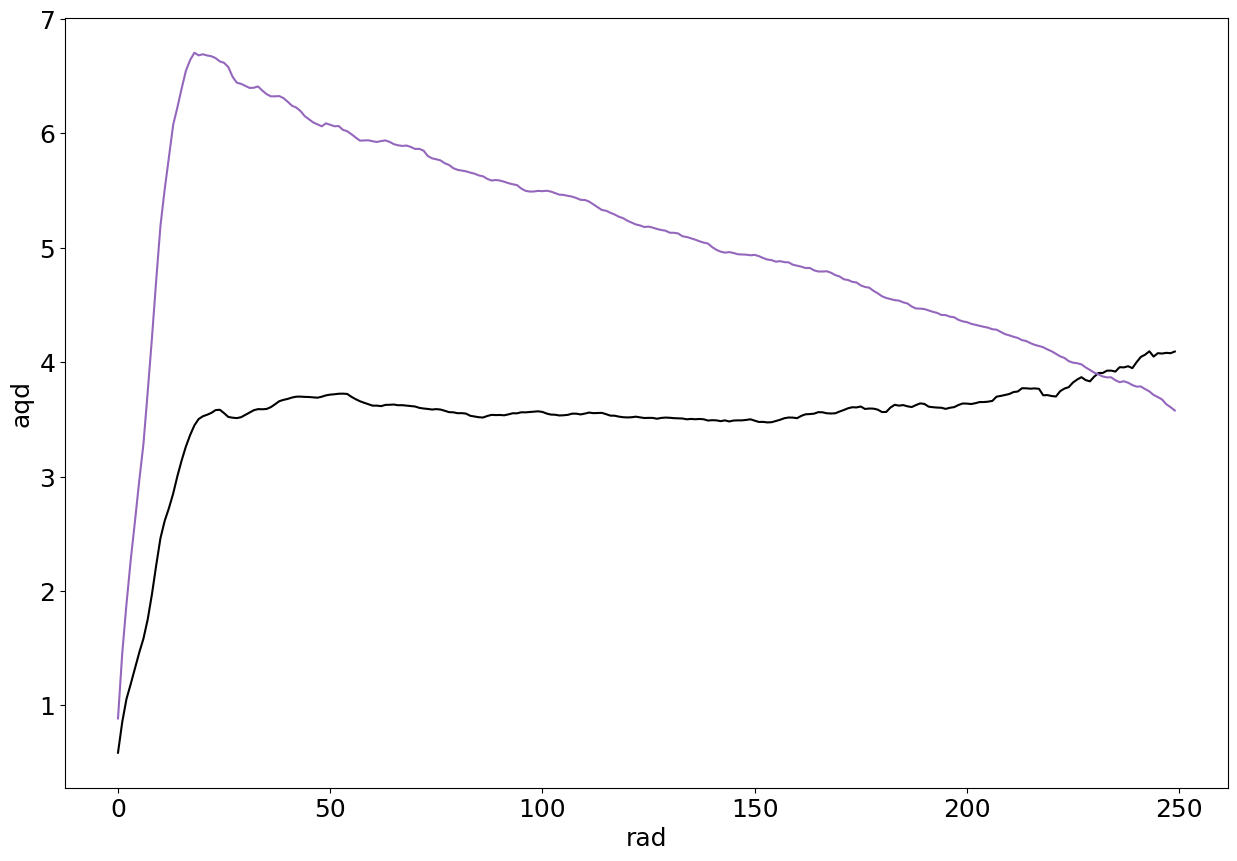

In [14]:
dsa.acn.mean(dim='time').plot(c='k')
dsa.aqd.mean(dim='time').plot(c='tab:purple')

In [15]:
VWS = [] # Wind shear
MOT = [] # Storm motion
RMX = [] # Rmax
SMD = [] # Storm motion direction
VWD = [] # Vertical wind shear direction
LAT = [] # Latitude, to filter Southern Hemisphere

for t in tqdm(range(len(dsa.time))):
    d_crt = d.where(d.file_tcva == dsa.isel(time=t).file_tcva, drop=True).isel(time=0)
    VWS.append(float(d_crt.vws_pmd))
    MOT.append(float(d_crt.speed))
    RMX.append(float(d_crt.rmx))
    SMD.append(float(d_crt.storm_dir_ibt))
    VWD.append(float(d_crt.wsd_pmd))
    LAT.append(float(d_crt.lat))

  0%|          | 0/640 [00:00<?, ?it/s]

In [16]:
dsa['wind_shear']     = xr.DataArray(data=VWS, dims='time')
dsa['storm_speed']    = xr.DataArray(data=MOT, dims='time')
dsa['rmx']            = xr.DataArray(data=RMX, dims='time')
dsa['storm_dir']      = xr.DataArray(data=SMD, dims='time')
dsa['wind_shear_dir'] = xr.DataArray(data=VWD, dims='time')
dsa['lat']            = xr.DataArray(data=LAT, dims='time')

In [17]:
# Update Southern hemisphere storms
dsa['storm_dir_adjusted']                    = dsa['storm_dir'].copy(deep=True)
dsa['storm_dir_adjusted'][dsa.lat < 0]      += 180

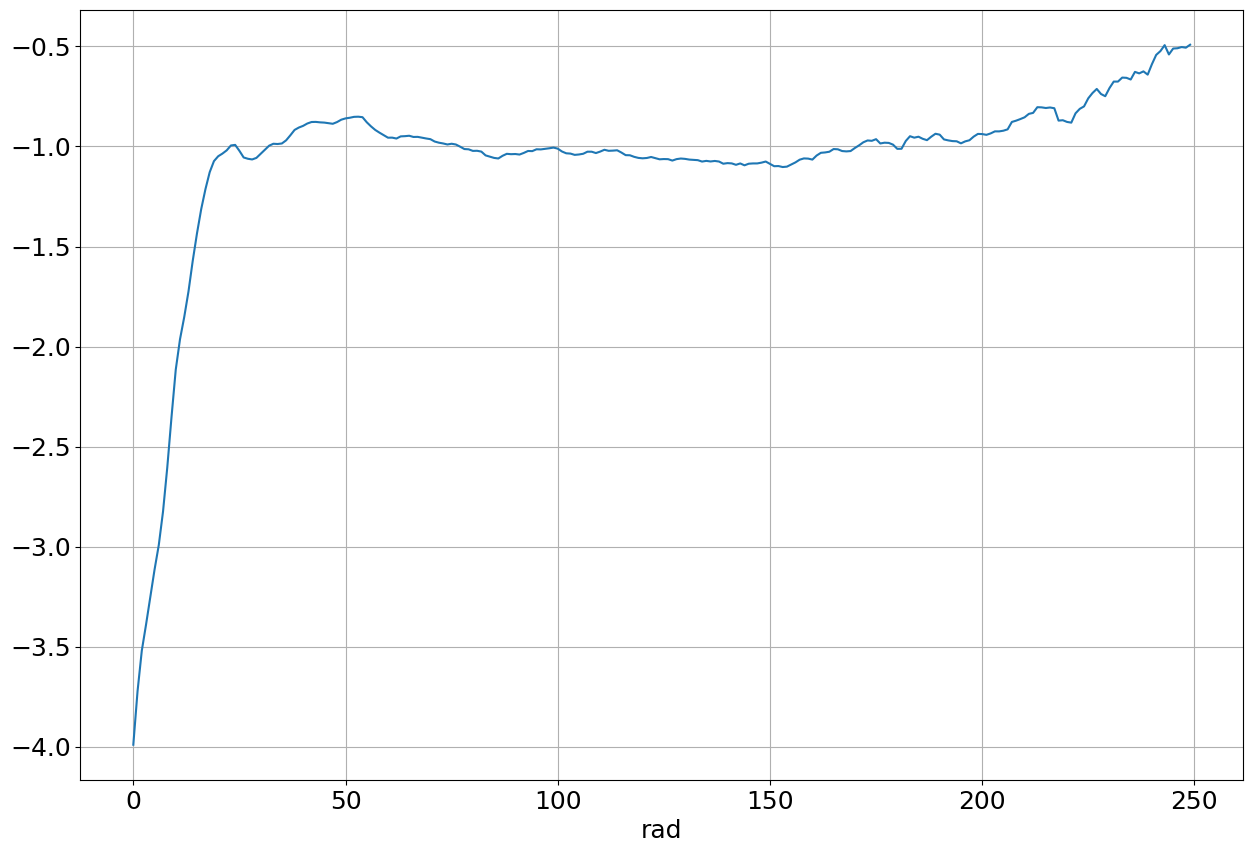

In [18]:
(dsa.acn - dsa.storm_speed).mean(dim='time').plot()
plt.grid()

In [19]:
dsa1 = dsa.where(dsa.wind_shear >= 8, drop=True)
dsa2 = dsa.where(dsa.wind_shear <  8, drop=True)

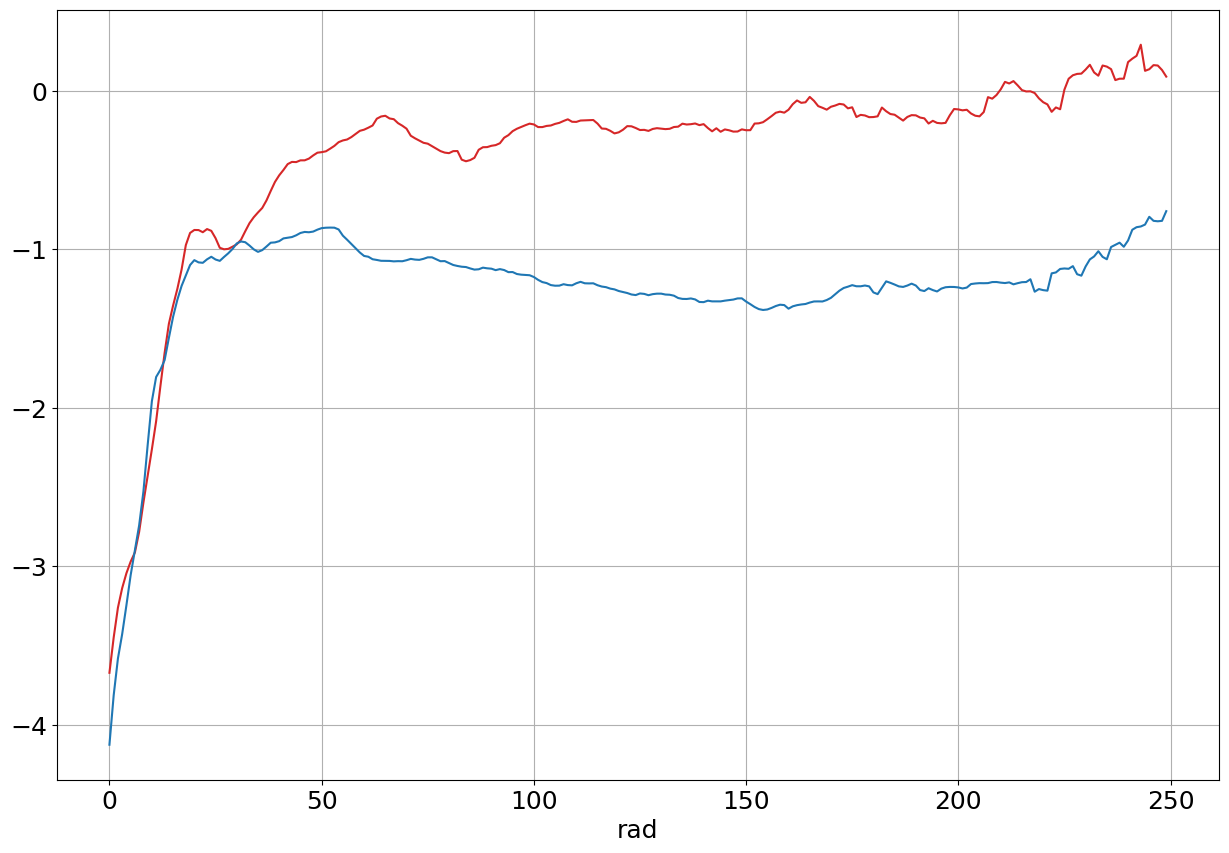

In [20]:
(dsa1.acn - dsa1.storm_speed).mean(dim='time').plot(c='tab:red')
(dsa2.acn - dsa2.storm_speed).mean(dim='time').plot(c='tab:blue')
plt.grid()

In [21]:
print(float(dsa1.rmx.mean()))

33085.427135678394


In [22]:
print(float(dsa2.rmx.mean()))

26495.702005730658


In [23]:
# delta = dsa.acn.max(dim='rad') - dsa.storm_speed

# plt.scatter(dsa.wind_shear, delta)
# plt.grid()

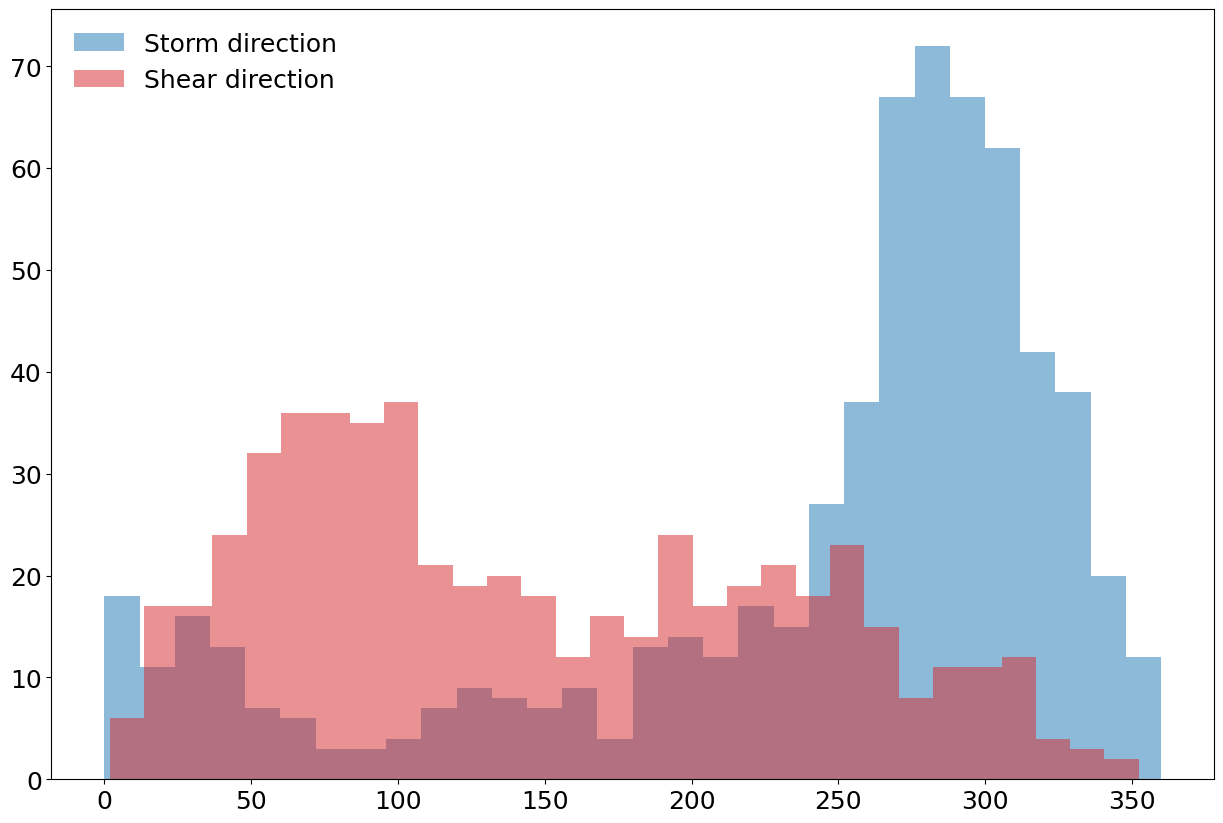

In [24]:
plt.hist(d.storm_dir_ibt, label='Storm direction', bins=30, alpha=0.5, color='tab:blue')
plt.hist(d.wsd_pmd,       label='Shear direction', bins=30, alpha=0.5, color='tab:red')
plt.legend(frameon=False)

In [25]:
# da = d.where(d.basin == 'al', drop=True)

# plt.hist(da.storm_dir_ibt, label='Storm direction', bins=30, alpha=0.5, color='tab:blue')
# plt.hist(da.wsd_pmd,       label='Shear direction', bins=30, alpha=0.5, color='tab:red')
# plt.legend(frameon=False)

29146.96485623003
28779.735682819384


(-4.0, 0.5)

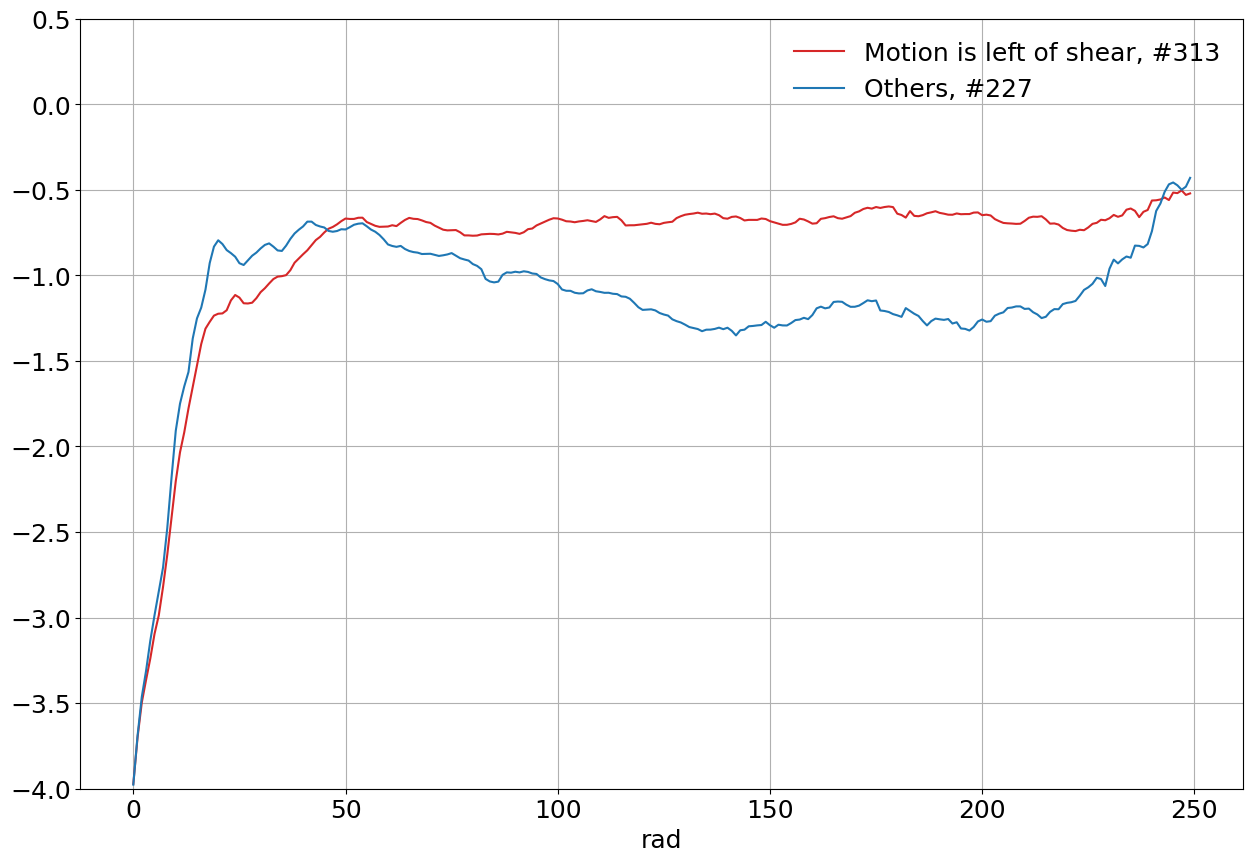

In [26]:
# motionIsXXofShear = ((dsa.wind_shear_dir - dsa.storm_dir) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir) % 360 <= 360)
motionIsXXofShear = ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 180)

dsa1 = dsa.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

(dsa1.acn - dsa1.storm_speed).mean(dim='time').plot(label='Motion is left of shear, #{}'.format(len(dsa1.time)), c='tab:red')
(dsa2.acn - dsa2.storm_speed).mean(dim='time').plot(label='Others, #{}'.format(len(dsa2.time)),                  c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 0.5)

30610.619469026547
28564.40281030445


(-4.0, 0.5)

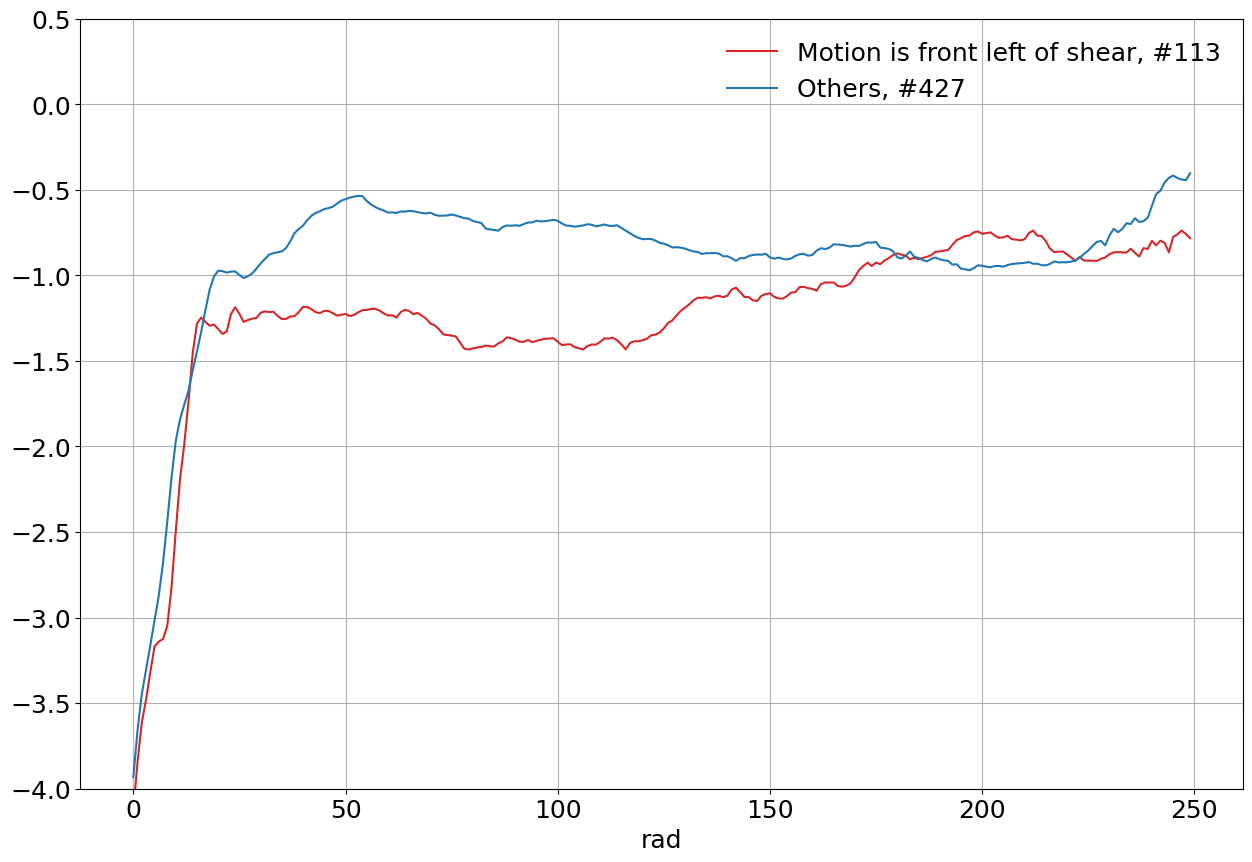

In [27]:
motionIsXXofShear = ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 0) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 90)

dsa1 = dsa.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

(dsa1.acn - dsa1.storm_speed).mean(dim='time').plot(label='Motion is front left of shear, #{}'.format(len(dsa1.time)), c='tab:red')
(dsa2.acn - dsa2.storm_speed).mean(dim='time').plot(label='Others, #{}'.format(len(dsa2.time)),                        c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 0.5)

26081.632653061224
29638.009049773755


(-4.0, 0.5)

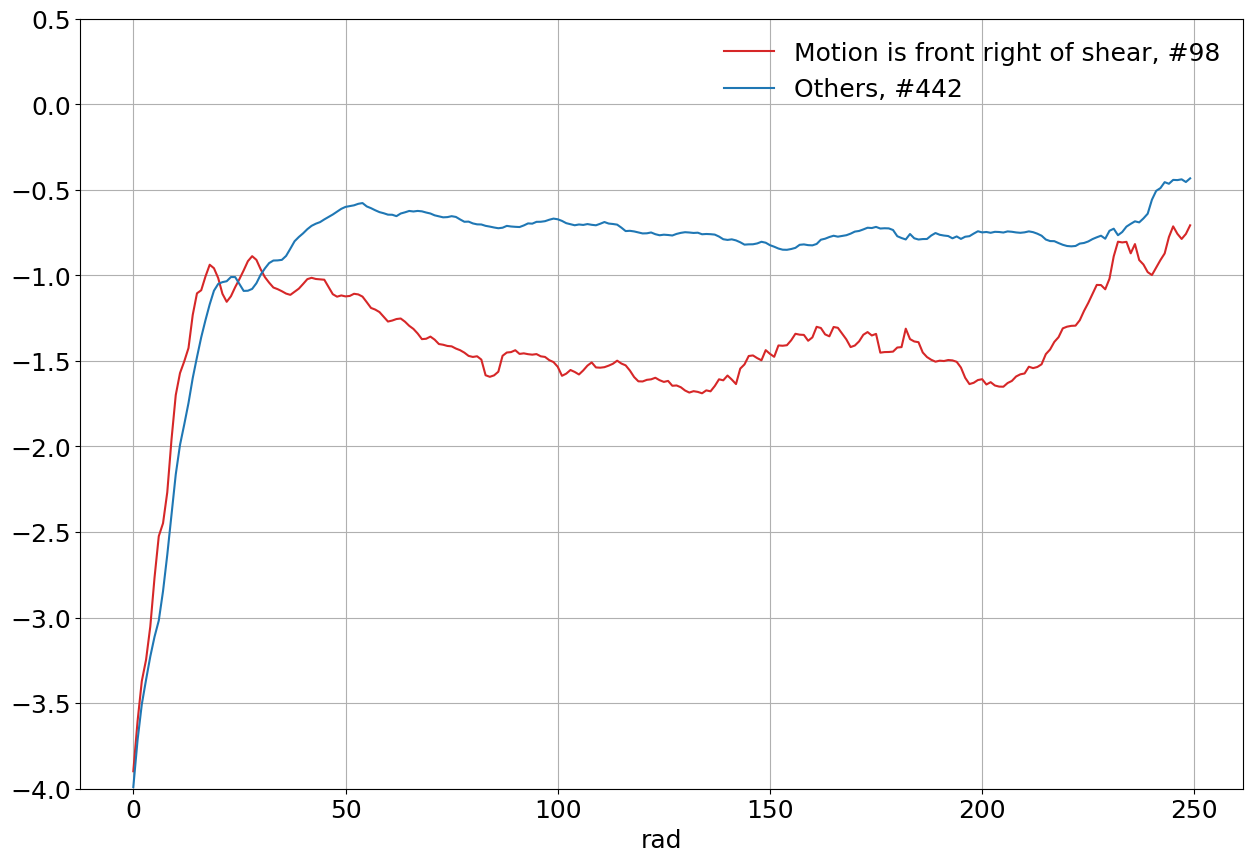

In [28]:
motionIsXXofShear = ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 270) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 360)

dsa1 = dsa.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

(dsa1.acn - dsa1.storm_speed).mean(dim='time').plot(label='Motion is front right of shear, #{}'.format(len(dsa1.time)), c='tab:red')
(dsa2.acn - dsa2.storm_speed).mean(dim='time').plot(label='Others, #{}'.format(len(dsa2.time)),                        c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 0.5)

30610.619469026547
28320.0
30829.457364341084
26081.632653061224


(-4.0, 1.0)

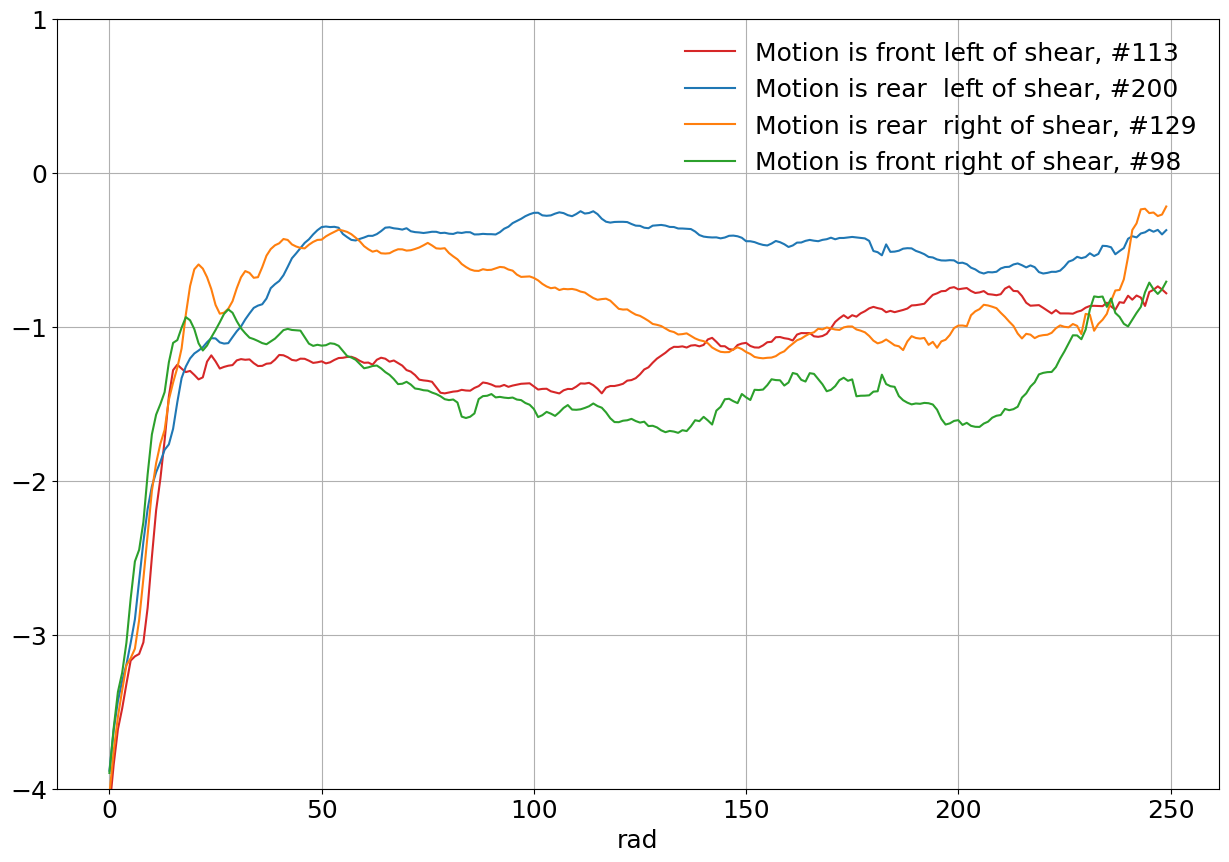

In [29]:
dsa1 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 0)   & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 90),  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 90)  & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 180), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa3 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 270), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa4 = dsa.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 270) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 360), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')


print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))
print(float(dsa3.rmx.mean()))
print(float(dsa4.rmx.mean()))

(dsa1.acn - dsa1.storm_speed).mean(dim='time').plot(label='Motion is front left of shear, #{}'.format(len(dsa1.time)),  c='tab:red')
(dsa2.acn - dsa2.storm_speed).mean(dim='time').plot(label='Motion is rear  left of shear, #{}'.format(len(dsa2.time)),  c='tab:blue')
(dsa3.acn - dsa3.storm_speed).mean(dim='time').plot(label='Motion is rear  right of shear, #{}'.format(len(dsa3.time)), c='tab:orange')
(dsa4.acn - dsa4.storm_speed).mean(dim='time').plot(label='Motion is front right of shear, #{}'.format(len(dsa4.time)), c='tab:green')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1)

(array([13., 25., 20., 15., 19., 14., 14., 16., 21., 26., 20., 27., 20.,
        23., 18., 15., 15., 11., 19., 16., 10., 19., 20., 23., 21., 16.,
        23., 19., 12., 18.]),
 array([3.01751797e-01, 1.22764210e+01, 2.42510901e+01, 3.62257593e+01,
        4.82004285e+01, 6.01750977e+01, 7.21497668e+01, 8.41244360e+01,
        9.60991052e+01, 1.08073774e+02, 1.20048444e+02, 1.32023113e+02,
        1.43997782e+02, 1.55972451e+02, 1.67947120e+02, 1.79921789e+02,
        1.91896459e+02, 2.03871128e+02, 2.15845797e+02, 2.27820466e+02,
        2.39795135e+02, 2.51769804e+02, 2.63744474e+02, 2.75719143e+02,
        2.87693812e+02, 2.99668481e+02, 3.11643150e+02, 3.23617820e+02,
        3.35592489e+02, 3.47567158e+02, 3.59541827e+02]),
 <BarContainer object of 30 artists>)

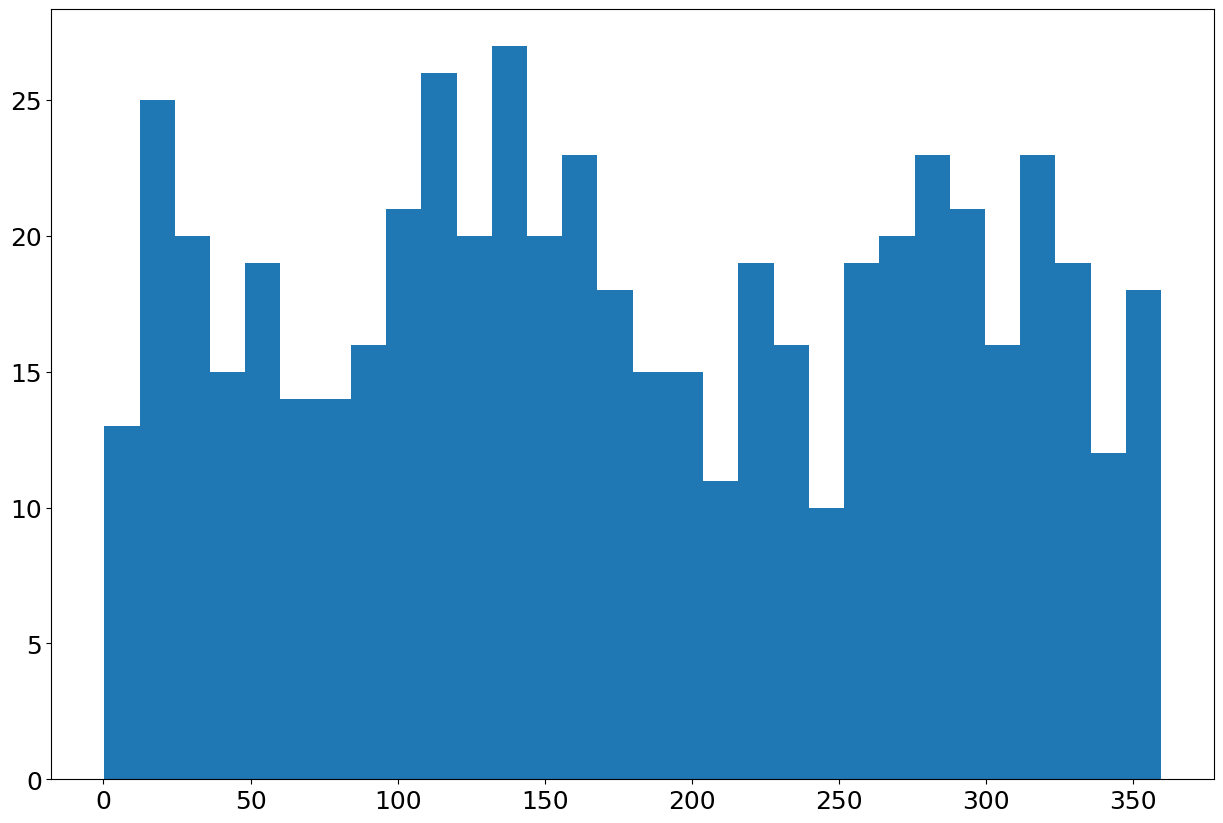

In [30]:
plt.hist((dsa.wind_shear_dir - dsa.storm_dir) % 360, bins=30)

### As a function of r* = r / Rmax

In [31]:
# Reference grid
r_star = np.linspace(0, 16, 321)
print(r_star)

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.85  3.9   3.95  4.    4.05  4.1   4.15
  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55  4.6   4.65  4.7   4.75
  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15  5.2   5.25  5.3   5.35
  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75  5.8   5.85  5.9   5.95
  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35  6.4   6.45  6.5   6.55
  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95  7.    7.05  7.1   7.15
  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55  7.6   7.65  7.7   7.75
  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15  8

In [32]:
L_ACN_STAR = []

for t in tqdm(range(len(dsa.time))):
    dsat     = dsa.isel(time=t)
    acn_star = np.interp(r_star, xs / float(dsat.rmx), dsat.acn)
    L_ACN_STAR.append(acn_star)

  0%|          | 0/640 [00:00<?, ?it/s]

In [33]:
dsa_star = xr.Dataset(
    data_vars={
        'acn':       (('time', 'rad'), L_ACN_STAR),
        'file_tcva': ('time', L_FIL),
    },
    coords={
        'time': TIMES
    }
)
dsa_star[list(dsa.keys())[3:]] = dsa[list(dsa.keys())[3:]]

(0.0, 6.0)

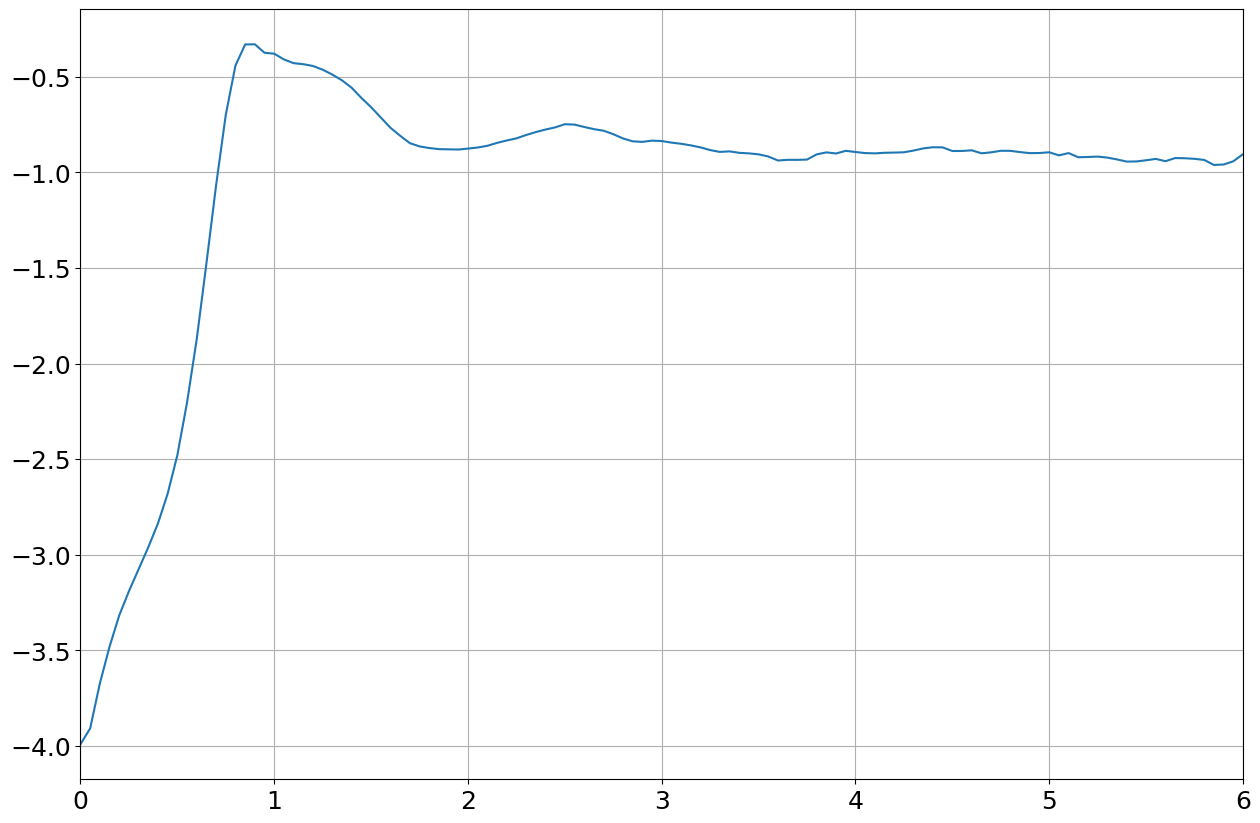

In [34]:
plt.plot(r_star, (dsa_star.acn - dsa_star.storm_speed).mean(dim='time'))
plt.grid()
plt.xlim(0, 6)

In [35]:
dsa1 = dsa_star.where(dsa_star.wind_shear >= 8, drop=True)
dsa2 = dsa_star.where(dsa_star.wind_shear <  8, drop=True)

(0.0, 6.0)

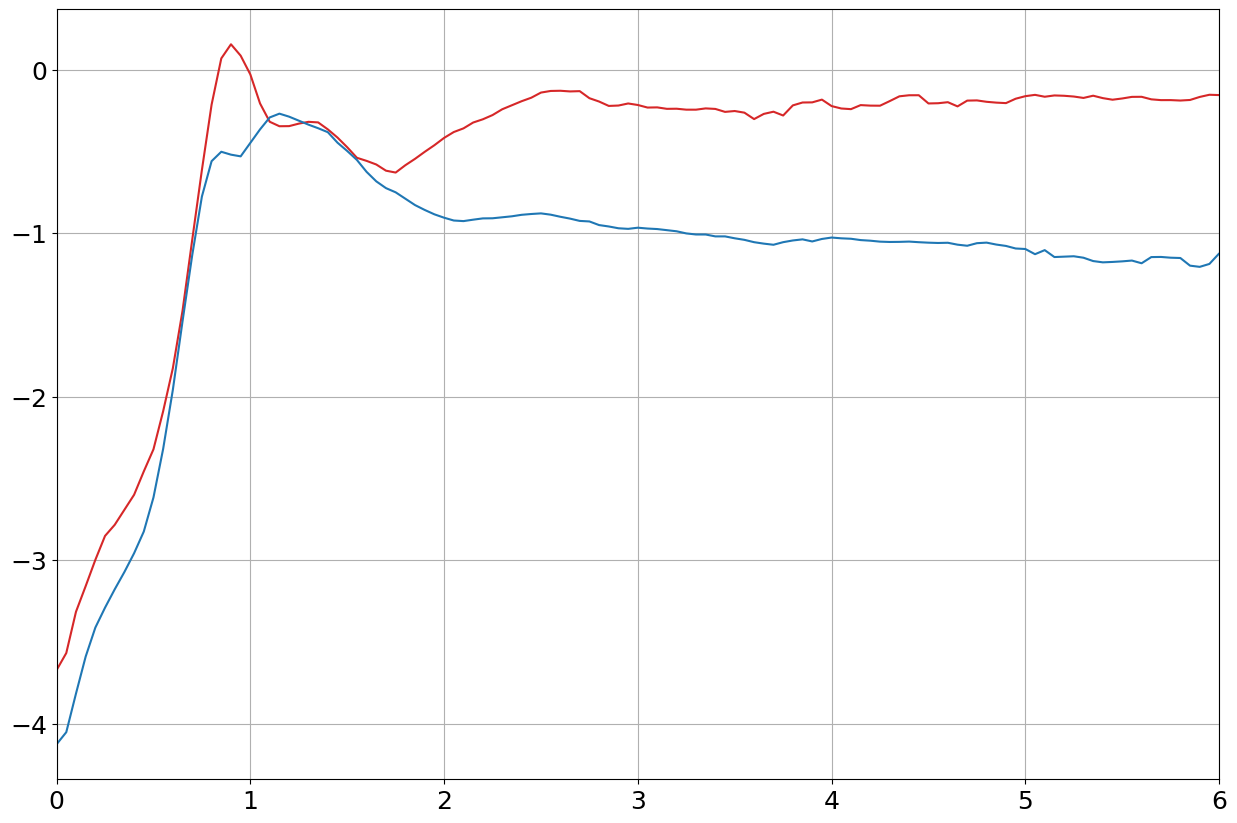

In [36]:
plt.plot(r_star, (dsa1.acn - dsa1.storm_speed).mean(dim='time'), c='tab:red')
plt.plot(r_star, (dsa2.acn - dsa2.storm_speed).mean(dim='time'), c='tab:blue')
plt.grid()
plt.xlim(0, 6)

29095.541401273884
28710.526315789473


(0.0, 6.0)

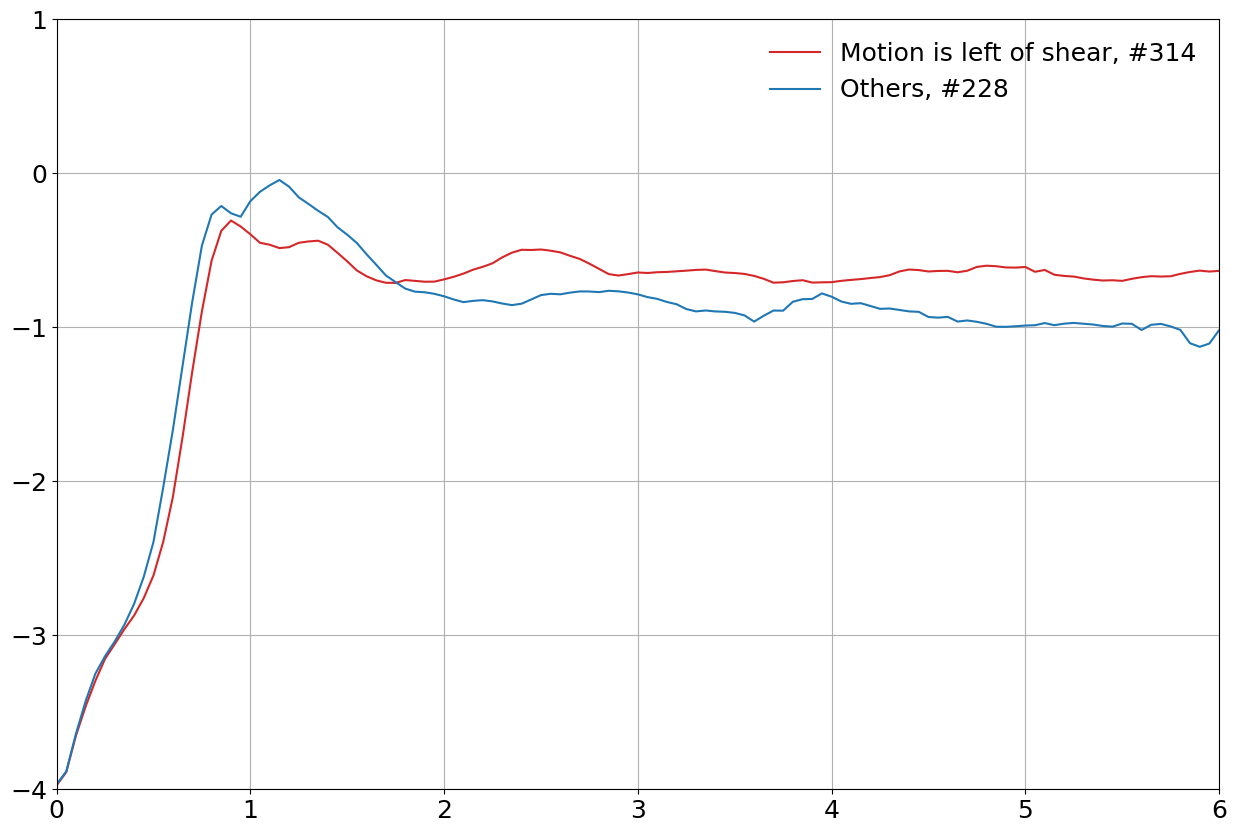

In [37]:
# motionIsXXofShear = ((dsa.wind_shear_dir - dsa.storm_dir) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir) % 360 <= 360)
motionIsXXofShear = ((dsa_star.wind_shear_dir - dsa_star.storm_dir_adjusted) % 360 <= 180)

dsa1 = dsa_star.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')
dsa2 = dsa_star.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

plt.plot(r_star, (dsa1.acn - dsa1.storm_speed).mean(dim='time'), label='Motion is left of shear, #{}'.format(len(dsa1.time)), c='tab:red')
plt.plot(r_star, (dsa2.acn - dsa2.storm_speed).mean(dim='time'), label='Others, #{}'.format(len(dsa2.time)),                  c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1)
plt.xlim(0, 6)

30610.619469026547
28491.841491841493


(0.0, 6.0)

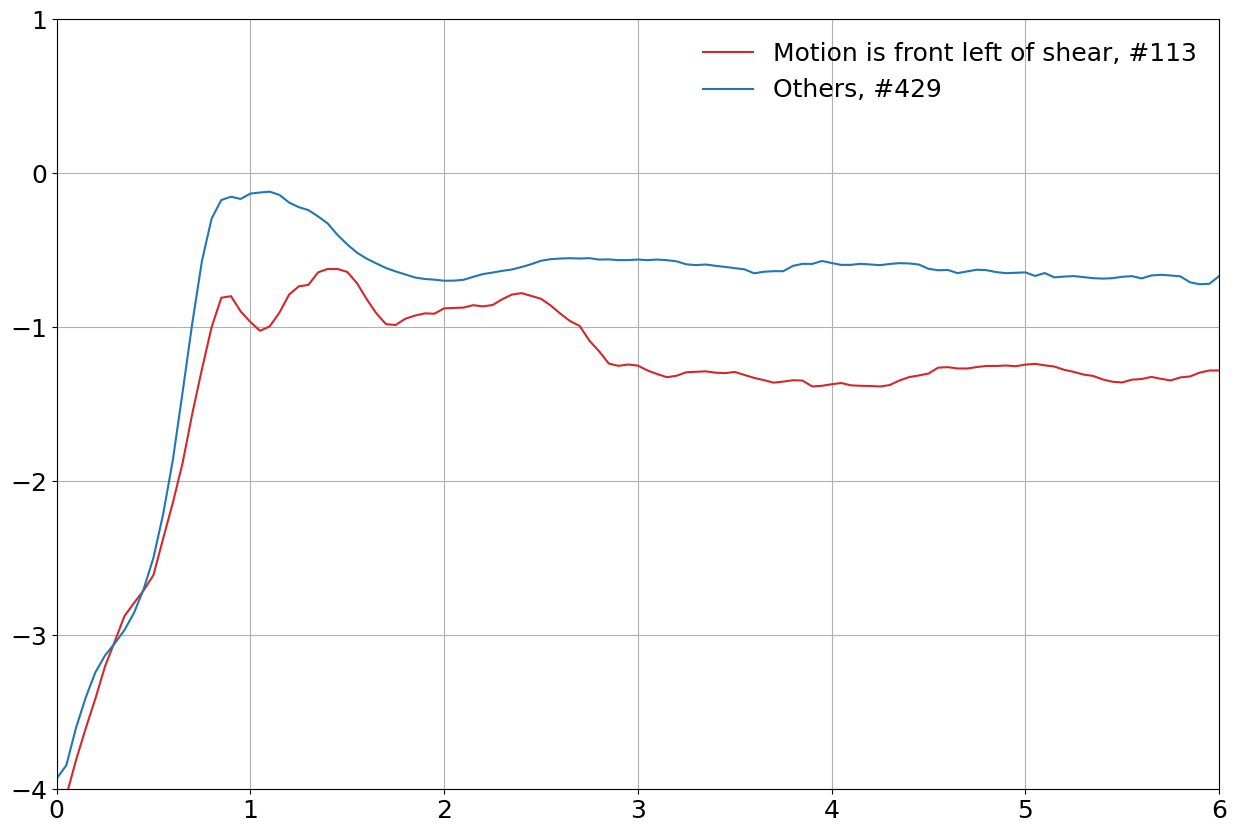

In [38]:
motionIsXXofShear = ((dsa_star.wind_shear_dir - dsa_star.storm_dir_adjusted) % 360 >= 0) & ((dsa_star.wind_shear_dir - dsa_star.storm_dir_adjusted) % 360 <= 90)

dsa1 = dsa_star.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')
dsa2 = dsa_star.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

plt.plot(r_star, (dsa1.acn - dsa1.storm_speed).mean(dim='time'), label='Motion is front left of shear, #{}'.format(len(dsa1.time)), c='tab:red')
plt.plot(r_star, (dsa2.acn - dsa2.storm_speed).mean(dim='time'), label='Others, #{}'.format(len(dsa2.time)),                        c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1)
plt.xlim(0, 6)

25949.49494949495
29600.451467268624


(0.0, 6.0)

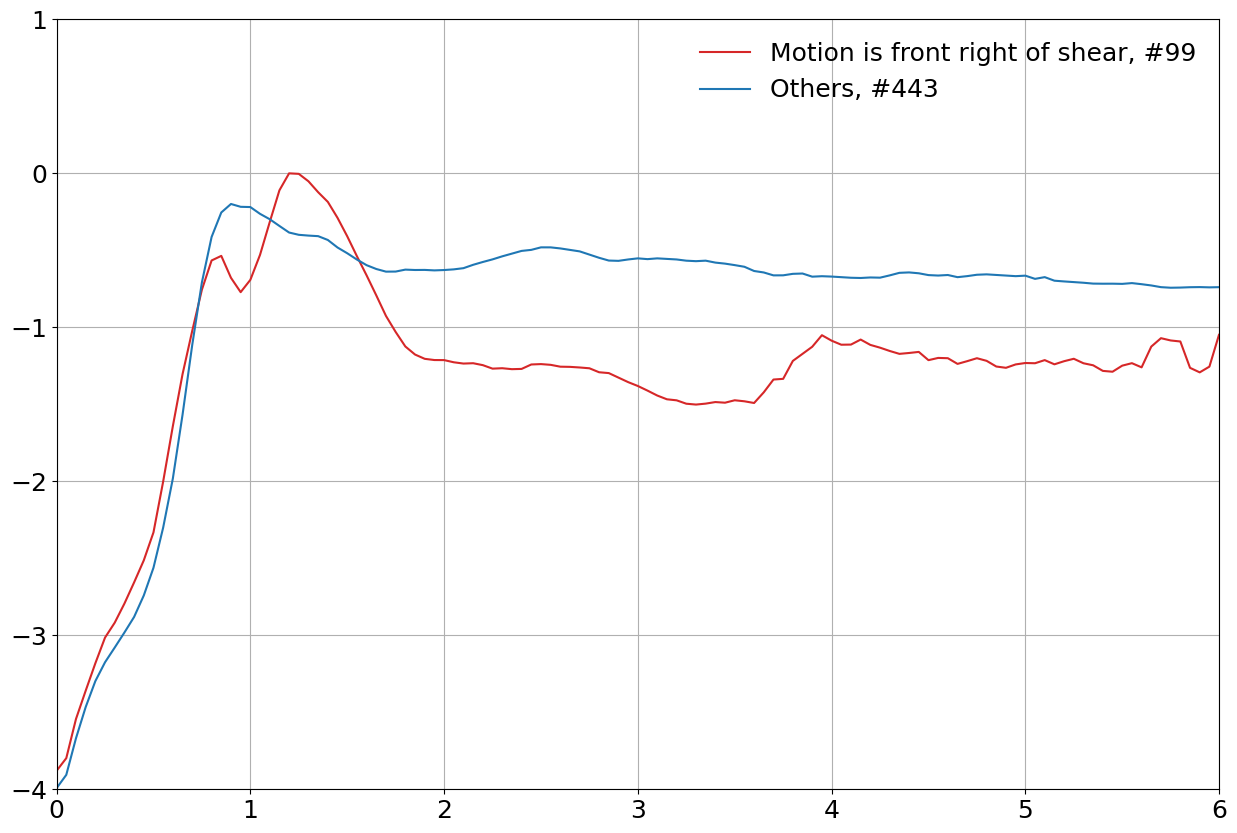

In [39]:
motionIsXXofShear = ((dsa_star.wind_shear_dir - dsa_star.storm_dir_adjusted) % 360 >= 270) & ((dsa_star.wind_shear_dir - dsa_star.storm_dir_adjusted) % 360 <= 360)

dsa1 = dsa_star.where(motionIsXXofShear,  drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')
dsa2 = dsa_star.where(~motionIsXXofShear, drop=True).where(~np.isnan(dsa_star.wind_shear)).dropna(dim='time')

print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))

plt.plot(r_star, (dsa1.acn - dsa1.storm_speed).mean(dim='time'), label='Motion is front right of shear, #{}'.format(len(dsa1.time)), c='tab:red')
plt.plot(r_star, (dsa2.acn - dsa2.storm_speed).mean(dim='time'), label='Others, #{}'.format(len(dsa2.time)),                        c='tab:blue')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1)
plt.xlim(0, 6)

30610.619469026547
28243.781094527363
30829.457364341084
25949.49494949495


(0.0, 6.0)

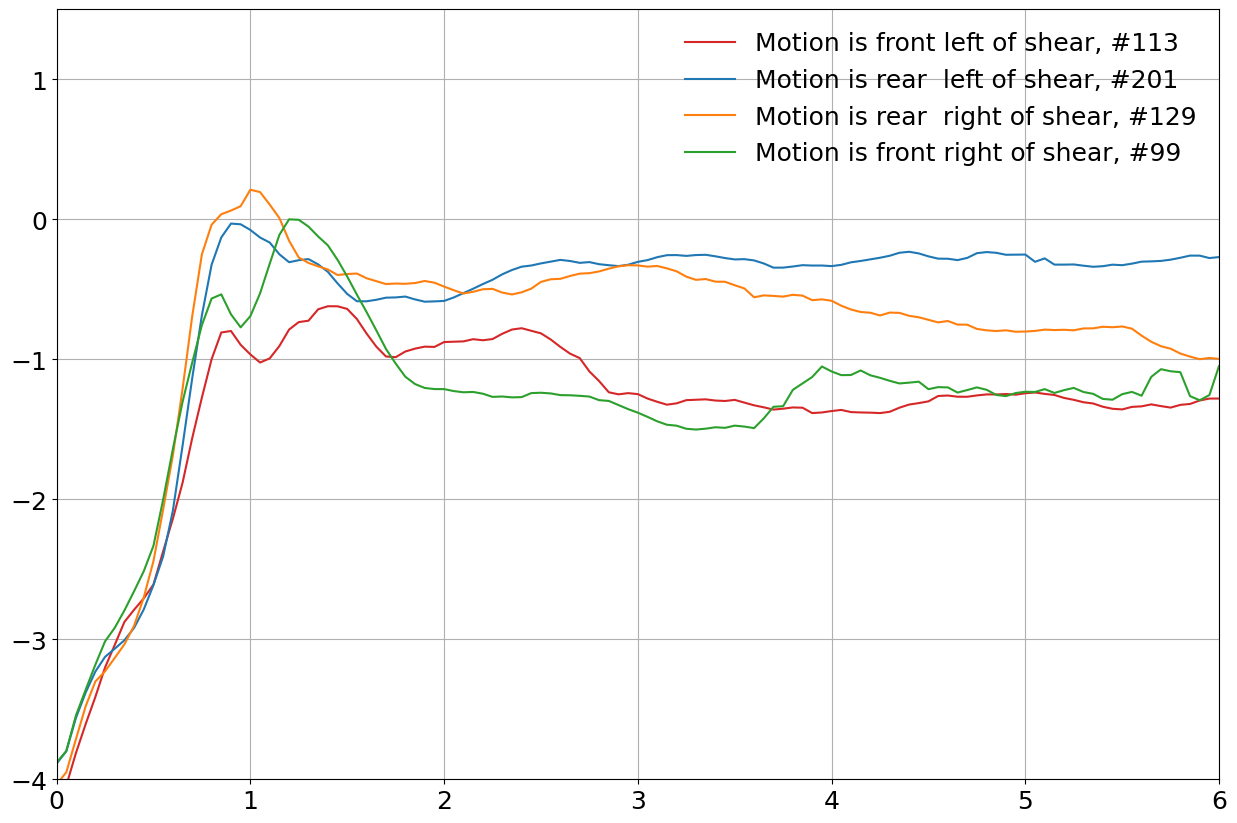

In [40]:
dsa1 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 0)   & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 90),  drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa2 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 90)  & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 180), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa3 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 180) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 270), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')
dsa4 = dsa_star.where(((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 >= 270) & ((dsa.wind_shear_dir - dsa.storm_dir_adjusted) % 360 <= 360), drop=True).where(~np.isnan(dsa.wind_shear)).dropna(dim='time')


print(float(dsa1.rmx.mean()))
print(float(dsa2.rmx.mean()))
print(float(dsa3.rmx.mean()))
print(float(dsa4.rmx.mean()))

plt.plot(r_star, (dsa1.acn - dsa1.storm_speed).mean(dim='time'), label='Motion is front left of shear, #{}'.format(len(dsa1.time)),  c='tab:red')
plt.plot(r_star, (dsa2.acn - dsa2.storm_speed).mean(dim='time'), label='Motion is rear  left of shear, #{}'.format(len(dsa2.time)),  c='tab:blue')
plt.plot(r_star, (dsa3.acn - dsa3.storm_speed).mean(dim='time'), label='Motion is rear  right of shear, #{}'.format(len(dsa3.time)), c='tab:orange')
plt.plot(r_star, (dsa4.acn - dsa4.storm_speed).mean(dim='time'), label='Motion is front right of shear, #{}'.format(len(dsa4.time)), c='tab:green')
plt.legend(frameon=False)
plt.grid()
plt.ylim(-4, 1.5)
plt.xlim(0, 6)